In [ ]:
# Import necessary libraries
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
from google.colab import drive

drive.mount('/content/drive')

img_rows = 640
img_cols = 360
channels = 3
img_shape = (img_rows, img_cols, channels)

pose_shape = (33, 2)

def load_data():
    data_file_path = '/content/pose_music_data.h5_5' 
    with h5py.File(data_file_path, 'r') as f:
        pose_data = f['video6266959903135372306/pose_landmarks'][:]  
        real_images = f['video6266959903135372306/frames'][:]  

    real_images = (real_images.astype(np.float32) / 127.5) - 1

    return pose_data, real_images

def train(epochs, batch_size=32, save_interval=200):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        idx = np.random.randint(0, pose_data.shape[0], half_batch)
        print(idx)
        pose_batch = pose_data[idx]
        real_image_batch = real_images[idx]
        gen_imgs = generator.predict(pose_batch)

        print(f"Epoch: {epoch + 1}")
        print(f"Pose batch shape: {pose_batch.shape}")
        print(f"Real images batch shape: {real_image_batch.shape}")
        print(f"Generated images shape: {gen_imgs.shape}")

        if gen_imgs.shape[0] != half_batch:
            print(f"Warning: Generated images batch size {gen_imgs.shape[0]} does not match half_batch {half_batch}.")
            continue 

        # Train the discriminator on real and generated images separately
        d_loss_real = discriminator.train_on_batch(real_image_batch, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        # Take the average loss for the discriminator
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator (to fool the discriminator)
        valid_y = np.ones((batch_size, 1))  # Target labels for generator training

        if pose_batch.shape[0] != batch_size:
            print(f"Warning: Pose batch size {pose_batch.shape[0]} does not match batch size {batch_size}. Adjusting.")
            pose_batch = np.tile(pose_batch, (batch_size // half_batch, 1, 1))[:batch_size]  # Repeat to fit batch size

        g_loss = combined.train_on_batch(pose_batch, valid_y)

        print(f"{epoch + 1}/{epochs} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss}]")

        if epoch % save_interval == 0:
            save_imgs(epoch)

def save_imgs(epoch):
    if not os.path.exists('images'):
        os.makedirs('images')

    r, c = 5, 5
    idx = np.random.randint(0, pose_data.shape[0], r * c)
    poses = pose_data[idx] 
    gen_imgs = generator.predict(poses)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt])
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"images/generated_{epoch}.png")
    plt.close()


pose_data, real_images = load_data()

print(f"Pose data shape: {pose_data.shape}")
print(f"Real images shape: {real_images.shape}")

optimizer = Adam(0.0002, 0.5)

# Load pre-trained generator model 
generator = load_model('/content/drive/MyDrive/Colab Notebooks/generator_model_new.keras')
print("Generator model loaded successfully.")

# Load pre-trained discriminator model
discriminator = load_model('/content/drive/MyDrive/Colab Notebooks/discriminator_model_new.keras')
print("Discriminator model loaded successfully.")

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# The generator takes pose data as input and generates images
pose_input = Input(shape=pose_shape)
img = generator(pose_input)

discriminator.trainable = False
valid = discriminator(img)

combined = Model(pose_input, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# Start training
train(epochs=5000, batch_size=32, save_interval=50)


198
1/1 [==============================] - 0s 288ms/step


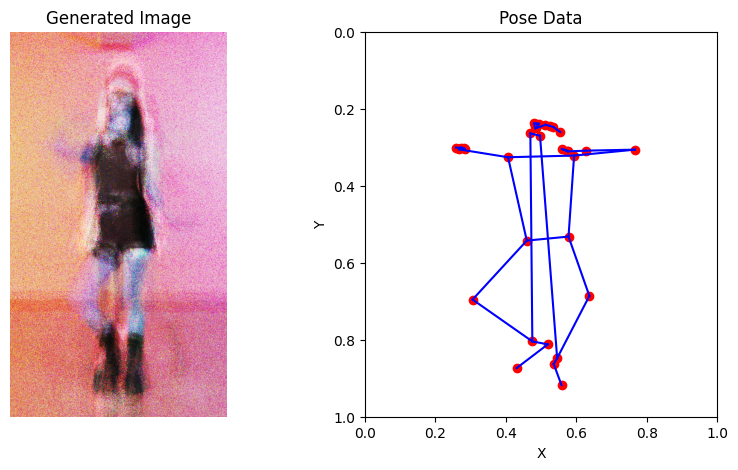

In [7]:

# Define pose connections
connections = [
    (0, 1), (1, 2), (2, 3), (3, 7),    # Nose to right shoulder
    (0, 4), (4, 5), (5, 6), (6, 8),    # Nose to left shoulder
    (9, 10), (11, 12), (11, 13), (13, 15),  # Body and arms
    (12, 14), (14, 16), (15, 17), (16, 18), # Arms and legs
    (17, 19), (19, 21), (16, 20), (20, 22), # Legs and feet
    (11, 23), (12, 24), (23, 24), (23, 25), (24, 26),  # Hips and legs
    (25, 27), (27, 29), (26, 28), (28, 30),  # Knees and ankles
    (29, 31), (31, 33), (30, 32), (32, 34),  # Feet
    (9, 27), (10, 28)  # Connecting the legs to the hips
]

random_index = np.random.randint(0, pose_data.shape[0])
print(random_index)

sample_pose = pose_data[random_index:random_index + 1]  

# Generate the image from the pose
generated_image = generator.predict(sample_pose)
generated_image = 0.5 * generated_image + 0.5  # Rescale to [0, 1]
generated_image = generated_image[0]

predicted_pose = sample_pose[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(generated_image)
axs[0].axis('off')
axs[0].set_title('Generated Image')

def visualize_pose(ax, landmarks):
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.invert_yaxis() 
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    x = landmarks[:, 0]
    y = landmarks[:, 1]

    ax.scatter(x, y, c='r', marker='o') 

    for (start_idx, end_idx) in connections:
        if start_idx < len(landmarks) and end_idx < len(landmarks):
            ax.plot([x[start_idx], x[end_idx]], [y[start_idx], y[end_idx]], 'b-')

    ax.set_title('Pose Data')

visualize_pose(axs[1], predicted_pose)

plt.show()
